In [2]:
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from skimage.exposure import histogram
import trackpy as tp
from scipy.ndimage import maximum_filter as mf
import pandas as pd
from scipy.ndimage.morphology import white_tophat

### Read the image
Read in the image file and check the shape. It is about 7 GB, so doing this with a fast network connection is a good idea. 

In [3]:
image = tifffile.imread('Data/00000-10-30-19_GapR-100nmBE.tiff')
image.shape

(270, 25, 2, 512, 512)

### Image Processing
Do some basic image processing
- Do a max projection
- delete the original image from memory
- make a variable that is just the gfp channel
- background subtrack using tophat white

In [4]:
pz = image.max(axis=(1))
del image

pzg = pz[:,1,:,:].astype(np.float32)
for i in range(pzg.shape[0]):
    pzg[i] = white_tophat(pzg[i], 29)

In [5]:
#np.save('pzg.npy', pzg)


### Check image
Use imshow to to display an image

(0.0, 16231.0, 318.2888)

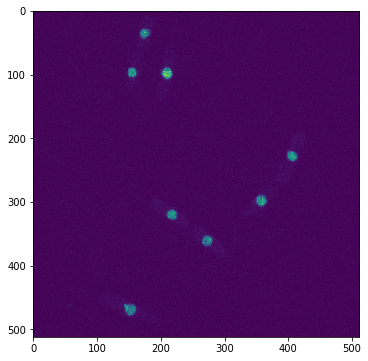

In [6]:
plt.figure(figsize=(6,6))
plt.imshow(pzg[6])
pzg[6].min(), pzg[6].max(), pzg.mean()

### Smooth image with gaussian filter
`nd.gaussian_filter` will filter in 3-d if a stack is input, so I am doing a list comprehension to do each slice individually.
- The list comprehension will return a list of 2-d arrays
- Use `np.stack` to make a stack from the list of arrays

In [7]:
gpzg_list = [nd.gaussian_filter(pzg[i,:,:], sigma=1) for i in range(pzg.shape[0])]
gpzg = np.stack(gpzg_list, axis=0)


(71.87272, 13316.622, 318.28915)

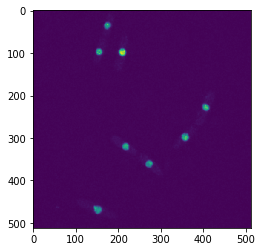

In [8]:
plt.imshow(gpzg[6])
gpzg[6].min(), gpzg[6].max(), gpzg.mean()

In [9]:
gpzg.shape, pzg.shape

((270, 512, 512), (270, 512, 512))

### TrackPy
To see how trackpy will perform, it can be tested on one slice with locate. The results can be shown with annotation.

Locate returns a pandas dataframe. Minmass is the integrated brightness.

#### Here is the top of the locate help
```
locate(raw_image, diameter, minmass=None, maxsize=None, separation=None, noise_size=1, smoothing_size=None, threshold=None, invert=False, percentile=64, topn=None, preprocess=True, max_iterations=10, filter_before=None, filter_after=None, characterize=True, engine='auto')
    Locate Gaussian-like blobs of some approximate size in an image.
```

In [10]:
#help(tp.locate)

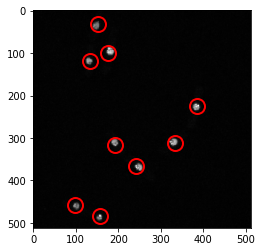

In [11]:
ix = 41
f = tp.locate(gpzg[ix], 11, minmass=40000)
tp.annotate(f, gpzg[ix])

In [12]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
36,32.496656,151.444562,72054.547152,3.126512,0.181359,1724.642452,397880.590759,0.003625
117,98.995298,177.052260,140254.011175,3.102499,0.219310,3677.546405,755402.908203,0.001864
135,117.960284,134.489216,96427.802982,2.933732,0.182623,2916.674735,528929.526855,0.002692
264,224.175074,386.471439,136754.001493,3.039673,0.182719,5300.739301,685129.930420,0.002060
374,311.695167,333.761863,115982.204901,3.311874,0.183819,2384.064566,660339.426758,0.002140


### Locate cells in everyframe
trackpy.batch will locate cells in every frame, fb is a dataframe.

In [13]:
fb = tp.batch(gpzg, 11, minmass=40000)
fb.head()

Frame 269: 14 features


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,35.270540,178.481616,43422.117874,3.197347,0.056376,1215.477653,214650.318970,0.003739,4
1,98.890916,157.043204,48967.324030,2.978995,0.272006,1576.835874,225894.156281,0.003546,4
2,103.755343,215.753117,59026.222875,3.020411,0.240045,1675.388116,298785.696838,0.002657,4
3,227.370147,409.999559,44677.016424,3.167018,0.059660,1176.056756,237410.011047,0.003368,4
4,298.852609,364.147010,51753.067407,3.223293,0.145986,1215.477653,255159.510864,0.003126,4


### Find trajectories
Use `tp.link` to link the coordinates in the `fb` dataframe in trajectories

In [14]:
dftrack = tp.link(fb, 11, memory=5)

Frame 269: 14 trajectories present.


In [15]:
dftrack[dftrack.particle == 5].head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
5,464.141926,149.492053,41339.380491,2.630056,0.106170,1616.256771,181373.797607,0.004457,4,5
13,465.061835,148.322793,61518.464173,2.684781,0.135404,2455.730802,278912.850769,0.004121,5,5
21,464.378463,146.088260,94870.680585,2.768978,0.132312,3211.132719,444568.771606,0.005002,6,5
29,463.137280,142.086229,76388.048465,2.576250,0.181387,3260.665303,400204.601501,0.004604,7,5
46,466.369120,139.884146,95127.882255,2.963887,0.296558,2879.524310,454617.381592,0.004190,9,5


In [16]:
### how many uniquie particles
dftrack.particle.unique().shape

(77,)

### Plot the trajectories

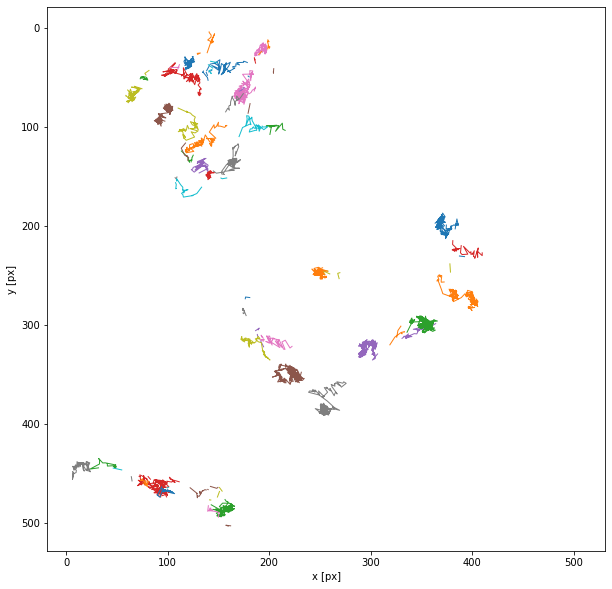

In [17]:
plt.figure(figsize=(10,10))
tp.plot_traj(dftrack)

### Create patches
- Create patches for every object that was found by trackpy.
- Make a mask of the cell using the mean as the threshold
- Calculate the mean intensity of the mask.

Every row in the dataframe will have a patch created for it

In [18]:
def get_patch(image, frame, cx, cy, size):
    x0 = int(cx) - size//2
    if x0 < 0:
        x0 = 0
    xf = x0 + size #int(cx) + size//2
    if xf >= image.shape[2]:
        xf = image.shape[2]
        x0 = xf - size
        
    y0 = int(cy) - size//2
    if y0 < 0:
        y0 = 0
    yf = y0 + 32
    if yf >=image.shape[1]:
        yf = image.shape[1]
        y0 = yf - 32
    
    res = image[frame, y0:yf, x0:xf]
    return res

patches = list()
frames = list()
mean_intensity = list()
mean_masks = list()
for row in dftrack.itertuples():
    patch = get_patch(pzg,row.frame, row.x, row.y, 32)
    patches.append(patch)
    frames.append(row.frame)
    mean_masks.append(np.where(patch > patch.mean(), 1, 0))
    mean_intensity.append(patch[patch > patch.mean()].mean())
reg = np.stack(patches, axis=0)
dftrack['mean_intensity'] = mean_intensity

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,mean_intensity
0,35.270540,178.481616,43422.117874,3.197347,0.056376,1215.477653,214650.318970,0.003739,4,0,1990.991455
1,98.890916,157.043204,48967.324030,2.978995,0.272006,1576.835874,225894.156281,0.003546,4,1,2586.736328
2,103.755343,215.753117,59026.222875,3.020411,0.240045,1675.388116,298785.696838,0.002657,4,2,3438.656982
3,227.370147,409.999559,44677.016424,3.167018,0.059660,1176.056756,237410.011047,0.003368,4,3,2541.062012
4,298.852609,364.147010,51753.067407,3.223293,0.145986,1215.477653,255159.510864,0.003126,4,4,2449.109131


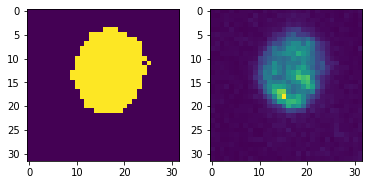

In [19]:
plt.subplot(121)
plt.imshow(mean_masks[416])
plt.subplot(122)
plt.imshow(reg[416])
dftrack.head()

In [20]:
from scipy.optimize import curve_fit
from skimage.morphology.extrema import h_maxima as hmx, local_maxima as lmx

### define the function for 2-d gaussian
def g2d(xdata, a, s1, x0, y0, q):
    x = xdata[0]
    y = xdata[1]
    t1 = a*np.exp(-((x-x0)**2 + (y - y0)**2)/(2*s1*s1))
    res = t1 + q
    res = res.ravel()
    return t1  + q

### function to find peaks in image patch
def get_peaks(image, h):
    gimage = nd.gaussian_filter(image, 1.)
    th = .25*image.max()
    hmax = hmx(image, th) #np.mean(image))
    return hmax.astype(np.float32) 

peak_list = list()
for i in range(reg.shape[0]):
    mi = dftrack.iloc[i]['mean_intensity']
    ### do this filter to blur the max points
    res = nd.gaussian_filter(get_peaks(reg[i], mi), 1)
    #print(res.max(), res.argmax())
    peak_list.append(res)
    

reg_peaks = np.stack(peak_list)


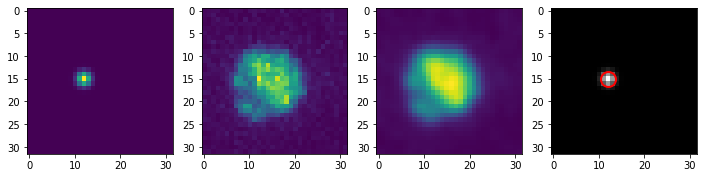

5542.3955 1527.8984


('####', 0.0, 1527.8984, 5542.3955, 12122.0)

In [21]:
pn = 1420
thresh = reg[pn][reg[pn] > reg[pn].mean()].mean()# + reg[pn][reg[pn] > reg[pn].mean()].std()
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(reg_peaks[pn])
plt.subplot(1,4,2)
plt.imshow(reg[pn])
plt.subplot(1,4,3)
plt.imshow(nd.gaussian_filter(reg[pn], 1.))
sx = tp.locate(reg_peaks[pn], diameter=5, separation=3, noise_size=.0001, minmass = 0) #thresh)
plt.subplot(1,4,4)
tp.annotate(sx, reg_peaks[pn])
print(reg[pn][reg[pn] > reg[pn].mean()].mean(), nd.gaussian_filter(reg[pn], 1).mean())
"####", reg[pn].min(), reg[pn].mean(), reg[pn][reg[pn] > reg[pn].mean()].mean(), reg[pn].max()

In [22]:

df_list = list()
nohno = 0
for i in range(dftrack.shape[0]):
    row = dftrack.iloc[i]
    #print(row)
    cell_frame = row.frame
    cell = row.particle
    cell_x = row.x
    cell_y = row.y
    
    thresh = reg[i][reg[i] > reg[i].mean()].mean()
    sdf = tp.locate(reg_peaks[i], diameter=3, separation=2,
                   topn=4, noise_size=.00001) #, minmass = thresh)
    
    if len(sdf) == 0:
        nohno += 1
        continue
    sdf['cell_x'] = row.x
    sdf['cell_y'] = row.y
    sdf['cell'] = int(row.particle)
    sdf['cell_frame'] = int(row.frame)
    sdf['cell_index'] = int(i)
    sdf['frame'] = int(row.frame)
    sdf['mean_intensity'] = row.mean_intensity
    df_list.append(sdf)
    #print(sdf.shape)

pdf = pd.concat(df_list, ignore_index=True)
print(nohno)

0


In [23]:
pdf.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,cell_x,cell_y,cell,cell_frame,cell_index,frame,mean_intensity
0,17.0,16.0,0.185206,0.779933,0.643939,0.072546,0.545288,6.090678e-09,178.481616,35.270540,0,4,0,4,1990.991455
1,18.0,14.0,0.185206,0.779933,0.643939,0.072546,0.545288,6.090678e-09,157.043204,98.890916,1,4,1,4,2586.736328
2,16.0,18.0,0.185206,0.779933,0.643939,0.072546,0.545288,6.090678e-09,215.753117,103.755343,2,4,2,4,3438.656982
3,16.0,18.0,0.185206,0.779933,0.643939,0.072546,0.545288,6.090678e-09,409.999559,227.370147,3,4,3,4,2541.062012
4,12.0,13.0,0.185206,0.779933,0.643939,0.072546,0.545288,6.090678e-09,364.147010,298.852609,4,4,4,4,2449.109131


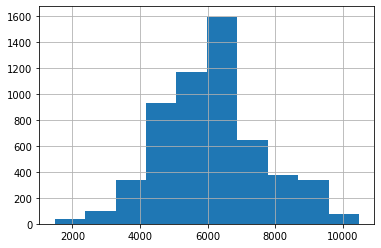

In [24]:
pdf.mean_intensity.hist()

In [25]:
dfcell_dict = dict()
for icell in pdf.cell.unique():
    _df = pdf[pdf.cell == icell]
    #dfcell_list.append(_df)
    dfcell_dict[int(icell)] = _df


In [26]:
#dfcell_dict.keys()

In [27]:
dflink_dict = dict()
for k, v in dfcell_dict.items():
    dflink = tp.link(v, 3, memory=2)
    dflink_dict[k] = dflink

Frame 269: 3 trajectories present.


### Get ready for fitting
Make a grid using `np.meshgrid`

In [28]:
ksize = 2

na = 2*ksize + 1
ex = np.linspace(0, na-1, na, dtype=np.float32)
ey = np.linspace(0, na-1, na, dtype=np.float32)
X, Y = np.meshgrid(ex,ey)
xdata = np.vstack([X.ravel(), Y.ravel()])
xdata.shape, X.ravel().shape

def get_patch2(row, ksize, stack):
    rx = int(np.round(row.x))
    ry = int(np.round(row.y))
    z0 = int(row.cell_index) #int(row.frame)
    x0 = rx - ksize 
    xf = rx + ksize + 1
    y0 = ry - ksize
    yf = ry + ksize + 1
    #print(z0, x0, xf, y0, yf)
    fpatch = reg[z0, y0:yf, x0:xf]
    return fpatch

xdata.shape, X.ravel().shape

((2, 25), (25,))

In [31]:
X, Y, xdata

(array([[0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.]], dtype=float32), array([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.]], dtype=float32), array([[0., 1., 2., 3., 4., 0., 1., 2., 3., 4., 0., 1., 2., 3., 4., 0.,
         1., 2., 3., 4., 0., 1., 2., 3., 4.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 3.,
         3., 3., 3., 3., 4., 4., 4., 4., 4.]], dtype=float32))

### Fitting spots
Fit every spot that was found before with a 2-d gaussian. Use the `trf` method because is has bounds.

In [32]:

def fitspots(adf, cellnum):
    fits = list()
    #adf = dflink_dict[cellnum]
    for row in adf.itertuples():
        try:
            fpatch = get_patch2(row, ksize, reg)/row.mean_intensity
            low = [.5*(fpatch.max() - fpatch.min()), .002, 0., 0., fpatch.min()]

            high = [2*(fpatch.max() - fpatch.min()),
                         20., 2*ksize, 2*ksize, fpatch.min()+ 4*fpatch.std()]

            p0 = [1.*(fpatch.max() - fpatch.min()),
                  na/4, ksize, ksize, fpatch.min() + .5*fpatch.std()]

            popt, pcov = curve_fit(g2d, xdata, fpatch.ravel(), p0=p0,
                                   method='trf', bounds=(low, high), maxfev=4000)
        except:
            print("can't fit,", cellnum, row.Index)
            continue
        popt = list(popt)
        popt.append(popt[0] + popt[-1])
        popt.append(row.x)
        popt.append(row.y)
        popt.append(row.mass)
        popt.append(row.frame)
        popt.append(row.particle)
        popt.append(row.cell_index)
        popt.append(row.cell)
        popt.append(row.cell_x)
        popt.append(row.cell_y)
        popt.append(cellnum)
        popt.append(row.mean_intensity)
        fits.append(popt)
        

    fdf = pd.DataFrame(fits, columns=['A', 'sigma', 'x0', 'y0', 'baseline', 'height',
                                      'x', 'y', 'mass', 'frame', 'particle', 'cell_index', 'cell',
                                     'cell_x', 'cell_y', 'cellnum', 'mean_intensity'])

    return fdf

cellnums = list(dflink_dict.keys())

celldf_list = list()
for num in cellnums:
    #print(num, dflink_dict[num].shape)
    _fdf = fitspots(dflink_dict[num], num)
    celldf_list.append(_fdf)

all_fdf = pd.concat(celldf_list)
all_fdf.shape

can't fit, 0 1169
can't fit, 1 1193
can't fit, 5 178
can't fit, 13 3176
can't fit, 15 698
can't fit, 57 5084


(5587, 17)

In [34]:
all_fdf.head()

,A,sigma,x0,y0,baseline,height,x,y,mass,frame,particle,cell_index,cell,cell_x,cell_y,cellnum,mean_intensity
0,1.865905,1.25,2.0,2.0,1.354125,3.220030,16.000000,17.000000,0.185206,4,0,0,0,178.481616,35.270540,0,1990.991455
1,1.971234,1.25,2.0,2.0,1.218968,3.190202,17.000000,16.000000,0.185206,5,0,12,0,175.643732,34.109470,0,3150.817871
2,1.903399,1.25,2.0,2.0,1.313260,3.216659,17.000000,16.000000,0.185206,6,0,14,0,174.616580,34.068934,0,5190.187988
3,1.248793,1.25,2.0,2.0,0.847767,2.096560,10.979656,14.998435,0.180988,7,1,29,0,174.856852,35.100567,0,5442.053223
4,1.646805,1.25,2.0,2.0,1.215686,2.862491,15.020867,15.982343,0.176456,7,0,29,0,174.856852,35.100567,0,5442.053223


In [35]:
sfdf = all_fdf[all_fdf.cellnum == 25]

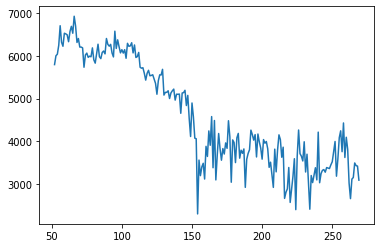

In [36]:
plt.plot(sfdf.frame, sfdf.mean_intensity)
#plt.scatter(sfdf.frame, sfdf.mean_intensity)

1.25 2.1338861733675003 2.0 2.0
8972.0


(1.6143574714660645,
 0.5195287019014359,
 1.25,
 2.1338861733675003,
 2.0,
 2.0,
 148.0,
 38.0,
 8972.0,
 1648.0,
 5617.52)

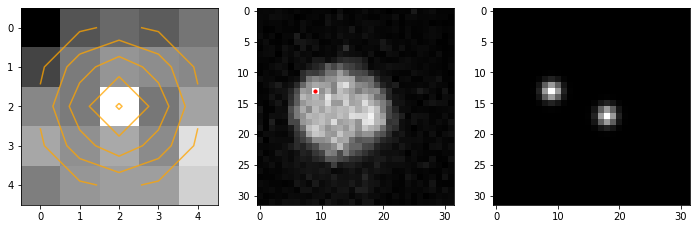

In [47]:
nn = 126
apatch = get_patch2(sfdf.iloc[nn], ksize, reg)
frow = sfdf.iloc[nn]
print(frow.sigma, frow.height, frow.x0, frow.y0)
ftp = g2d(xdata, frow.A, frow.sigma, frow.x0,frow.y0, frow.baseline)
#plt.imshow(apatch)

#pd = pd.reshape((na, na))
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax1.imshow(apatch, cmap='gray')
ax1.contour(X, Y, ftp.reshape(5,5), 4, colors='orange', alpha=.75)

ax2 = fig.add_subplot(132)
ax2.imshow(reg[int(frow.cell_index)], cmap='gray')
ax2.scatter(frow.x, frow.y, color='red', s=10)
#ax2.scatter(frow.x, frow.y,color='red', s=10)

ax2 = fig.add_subplot(133)
ax2.imshow(reg_peaks[int(frow.cell_index)], cmap='gray')


print(apatch.max())
frow.A, frow.baseline, frow.sigma, frow.height, frow.x0, frow.y0, frow.frame, frow.particle,apatch.max(), apatch.min(), apatch.mean()

In [38]:
#print(sfdf.groupby("particle").agg("count"))
sfdf[sfdf.particle==0]

,A,sigma,x0,y0,baseline,height,x,y,mass,frame,particle,cell_index,cell,cell_x,cell_y,cellnum,mean_intensity
0,1.725593,1.25,2.0,2.0,0.773714,2.499307,17.000000,13.000000,0.185206,52,0,426,25,220.151332,356.933765,25,5799.165527
3,2.697865,1.25,2.0,2.0,1.134272,3.832136,17.040258,14.982287,0.172494,55,0,465,25,222.487751,353.175400,25,6252.723633
5,2.415378,1.25,2.0,2.0,0.961280,3.376658,18.009317,14.998447,0.182848,56,0,480,25,221.747917,354.429924,25,6711.578125


In [ ]:
gdf = sfdf[sfdf['particle'] == 1]
print(gdf.shape)
plt.scatter(gdf.frame, gdf.height)
plt.plot(gdf.frame, gdf.height)

In [ ]:
all_fdf.to_csv("103019-spots-normalized.csv")

In [ ]:
all_fdf.to_pickle("103019-spots-normalized.pkl")